### Please check this video for better understanding :)

In [3]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


## End to End Dog Breed Multi Class Classification
### 1.Problem
There are 120 breeds of dog in the data. We have to identify according to their breeds.
### 2.Data
There are training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs.
* train.zip - the training set, you are provided the breed for these dogs
* test.zip - the test set, you must predict the probability of each breed for each image
* sample_submission.csv - a sample submission file in the correct format
* labels.csv - the breeds for the images in the train set

### Evaluation
Cross entropy loss.
### Features
* we are dealing with the unstructure data set.
* There are about 10000+ images in the training data.
* There are about 10000+ images in the test data.

Now Since we have unstructured data we have to work with the library like tensorflow. so lets import the necessary libraries and directly jump into the project

In [4]:

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
#reading labels csv file

labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
#describe
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,8c6264cf21c69e5fb58ba291c45e7049,scottish_deerhound
freq,1,126


In [52]:
# #total unique breeds

labels['breed'].nunique()

120

**Observation:**
1. We have total 120 unique breeds
2. We have atleast 60 images per category of breed
3. Google recommends at least 10 images per class to bet a better model
4. More sample available ----- > More efficeint the model will be

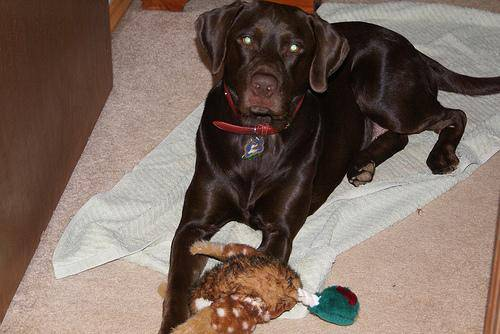

In [9]:
# Lets check one image
from IPython.display import display, Image
Image("../input/dog-breed-identification/train/43572ba7edf772a95f539e57afd9eb43.jpg")

In [10]:
import os
if len(os.listdir('/kaggle/input/dog-breed-identification/train/')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [11]:

#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num


Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

**One-hot Encoding:**
Since the output of our predictor for each input is a vector of probabilities for each class we must convert out label dataset to be the same format. That is for each input a row vector of length num_classes with a 1 at the index of the label and 0's everywhere else.

In [12]:

input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [13]:
import time 
t = time.time()

X,y = images_to_array('/kaggle/input/dog-breed-identification/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 96.8317379951477


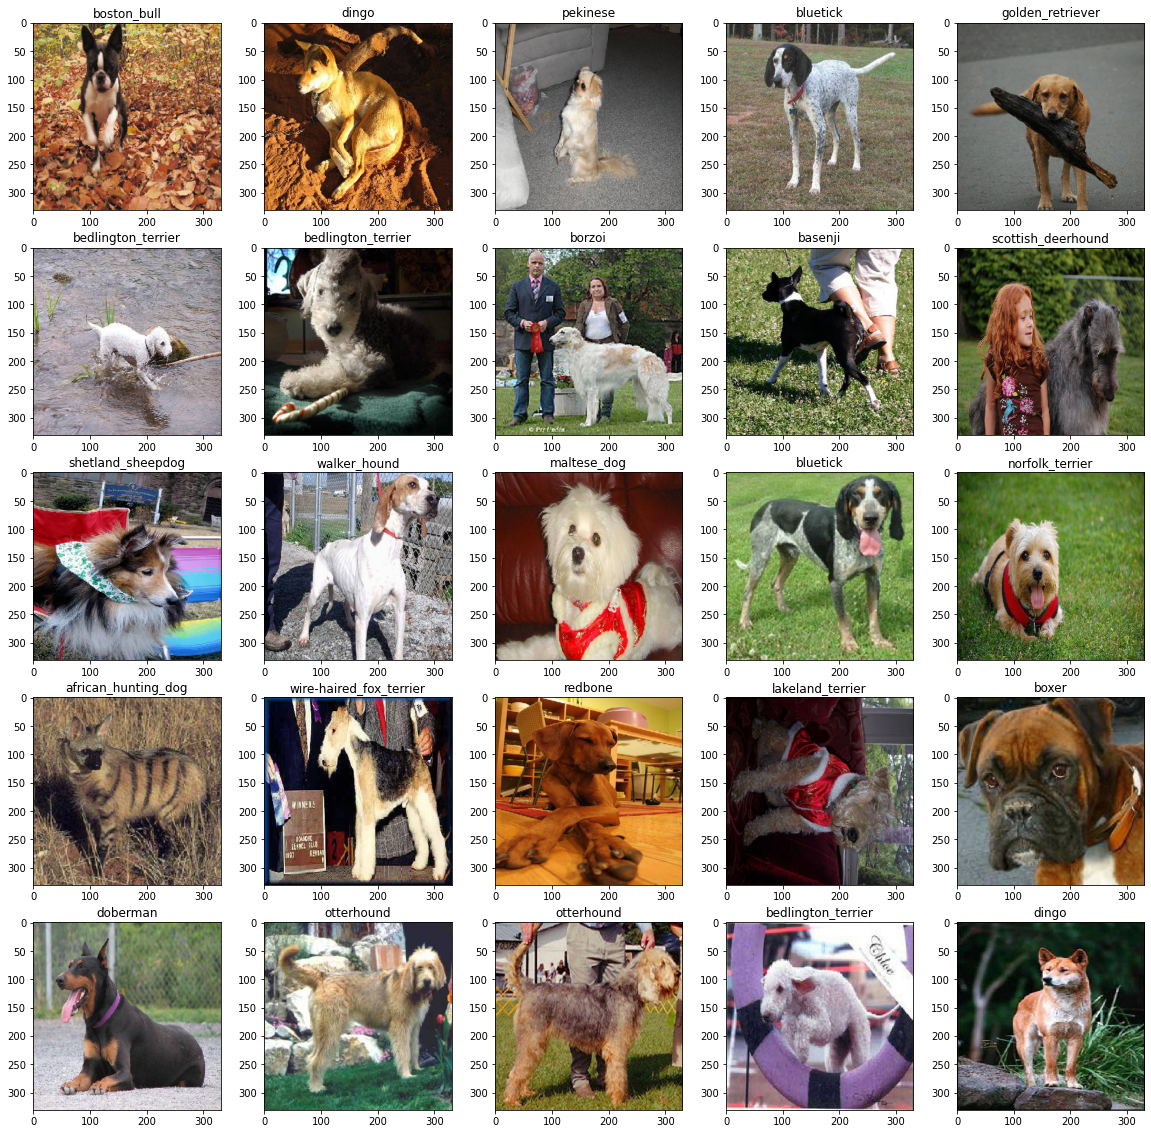

In [17]:
# np.where(y[5]==1)[0][0]

# lets check some dogs and their breeds
n=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image
    

### Creating callbacks:

(things to help our model)

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.

In [18]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [19]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Model Building:

* The basic idea here is to extract features from the data set from pretrained models and create a simple deep net by using all those features combined.
* So we will GlobalAveragePooling2D to extract a pooled output from our selected models
* img_size = You can change this shape according to the documentation of the pretrained model
* Keras documentation for all models: https://keras.io/api/applications/



In [20]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [21]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

320/320 [==============================] - 33s 88ms/step
Feature maps shape:  (10222, 2048)


In [22]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

320/320 [==============================] - 50s 153ms/step
Feature maps shape:  (10222, 2048)


In [23]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

320/320 [==============================] - 73s 217ms/step
Feature maps shape:  (10222, 1536)


In [24]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

320/320 [==============================] - 180s 544ms/step
Feature maps shape:  (10222, 4032)


In [25]:
del X #to free up some ram memory
gc.collect()

99980

In [26]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)



Final feature maps shape (10222, 9664)


In [27]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 1s 9ms/step - loss: 2.2047 - accuracy: 0.5798 - val_loss: 0.1874 - val_accuracy: 0.9438
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1659 - accuracy: 0.9507 - val_loss: 0.1897 - val_accuracy: 0.9369
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1477 - accuracy: 0.9492 - val_loss: 0.1795 - val_accuracy: 0.9418
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1123 - accuracy: 0.9652 - val_loss: 0.1808 - val_accuracy: 0.9447
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0860 - accuracy: 0.9729 - val_loss: 0.1850 - val_accuracy: 0.9369
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0822 - accuracy: 0.9711 - val_loss: 0.1872 - val_accuracy: 0.9428
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.9827 - val_loss: 0.1967 - val_accuracy: 0.9438
Epoch 8/50
64/64 [==

In [28]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

1852

In [31]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)

  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 331, 331, 3)


In [32]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

324/324 [==============================] - 30s 88ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 50s 153ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 181s 545ms/step
Feature maps shape:  (10357, 4032)
324/324 [==============================] - 74s 218ms/step
Feature maps shape:  (10357, 1536)
Final feature maps shape (10357, 9664)


In [33]:
#Free up some space.
del test_data
gc.collect()

23

In [34]:
#Predict test labels given test data features.

pred = model.predict(test_features)

In [35]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[1.65901274e-05 4.11923293e-06 2.30835103e-05 4.48232322e-06
 1.35011539e-01 1.02931925e-04 1.04962688e-04 1.66154059e-04
 7.35490403e-06 3.23474815e-05 1.14997574e-05 1.42503313e-06
 3.73433613e-06 1.19879087e-05 7.21676224e-06 2.20868515e-05
 8.13226434e-05 1.17942509e-04 4.12044301e-06 4.52361826e-04
 6.79404839e-05 1.91366230e-03 9.74751892e-05 1.45703389e-05
 9.64021910e-06 2.29701211e-04 1.16575335e-04 4.62301323e-05
 8.60456639e-05 1.53428900e-05 4.90637321e-05 1.32260966e-05
 5.68826681e-06 1.44597361e-05 2.72250622e-06 2.15154596e-05
 4.42768905e-05 2.36136202e-05 1.63394943e-05 2.70300134e-05
 2.82295173e-06 3.29779118e-06 6.19165530e-06 6.09643357e-05
 6.97632595e-06 2.05897333e-04 3.92224911e-06 1.15791909e-05
 5.40298197e-06 1.08647664e-05 4.13332873e-06 7.95262349e-06
 7.12576366e-06 2.07388657e-05 6.71043608e-06 1.79493600e-05
 6.33145419e-06 2.78651769e-05 8.09278754e-06 1.65752936e-05
 2.45649589e-05 1.43292427e-05 9.10617109e-06 3.10592986e-05
 4.78838665e-05 2.571519

In [36]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [37]:
# Append test image ID's to predictions DataFrame
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,1.65901e-05,4.11923e-06,2.30835e-05,4.48232e-06,0.135012,0.000102932,0.000104963,0.000166154,7.3549e-06,...,1.54697e-05,0.00018654,1.48496e-05,3.89079e-05,2.58178e-06,6.859e-06,2.53522e-05,0.000525696,2.47165e-05,2.46211e-05
1,f7a32505c12649183c5991ecfa7d68b3,2.82147e-07,2.6459e-07,1.41009e-07,1.94703e-07,2.68134e-07,5.96907e-07,1.6536e-07,4.23923e-07,5.13706e-06,...,2.50456e-07,1.11166e-07,1.8712e-05,1.0829e-05,7.24624e-07,4.09376e-07,8.74803e-08,3.41125e-07,4.84228e-08,1.73982e-07
2,bc6d50ffb4644feb34530aa58943e85b,1.90471e-06,3.99711e-05,4.82559e-06,3.45414e-06,3.26811e-06,2.01678e-05,9.59014e-07,7.43605e-07,3.52527e-06,...,3.5484e-06,1.02948e-06,2.38388e-06,9.37104e-06,5.08696e-06,2.73364e-06,1.4284e-07,1.15778e-05,3.58079e-07,8.9423e-07
3,7cbc041e79135a572aad87904b5c9c57,2.38681e-06,1.89494e-06,1.76562e-06,2.93892e-06,7.60436e-06,8.81008e-06,1.51775e-06,4.51684e-06,7.04669e-07,...,6.31154e-06,1.89257e-05,2.82618e-06,1.83693e-06,0.000156287,6.57656e-07,3.99633e-07,0.0016432,8.32823e-07,2.06658e-06
4,f3b603f10d6a344f0395fb46b242ff8e,4.38524e-06,5.49657e-06,5.44791e-06,5.86013e-06,2.45163e-06,3.85447e-05,6.55866e-06,4.34468e-06,9.24812e-05,...,5.27011e-06,2.12586e-06,3.69182e-06,2.13724e-05,3.90112e-06,0.997237,1.959e-06,7.12783e-06,6.2732e-06,3.69529e-06


# Testing with custom input:

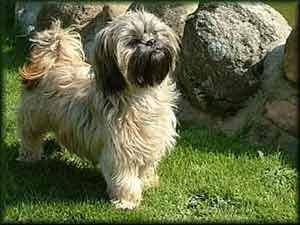

In [48]:
#Custom input

Image('../input/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg')

In [49]:
#reading the image and converting it into an np array

img_g = load_img('../input/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) # as we trained our model in (row, img_height, img_width, img_rgb) format, np.expand_dims convert the image into this format


In [50]:
img_g.shape

(1, 331, 331, 3)

In [43]:
# #Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 1s 727ms/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 6s 6s/step
Feature maps shape:  (1, 4032)
1/1 [==============================] - 3s 3s/step
Feature maps shape:  (1, 1536)
Final feature maps shape (1, 9664)
Predicted label: lhasa
Probability of prediction): 100 %


## Save the model

In [51]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
